**Note!**

This notebook uses the `nilearn` package - which is not a requirement of `pynm` and must be installed.

To do so, uncomment the code in the cell below and run it.

In [1]:
#import sys
#!{sys.executable} -m pip install nilearn==0.9.2

In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# **Model Selection**
In this tutorial we'll use a real dataset to demonstrate using cross-validation for model selection.

## **Cross-Validation**
The basic idea of cross-validation is to repeat the training and test process on the data multiple times to get a more stable evaluation of a model. In PyNM we've implemented cross-validation as a step before the ordinary model fit to help with model selection:
- For K iterations:
    - The training sample is shuffled and split again into training and test sets.
    - The model is fit on the training set and evaluated on the test set.
- The model evaluation for each fold is then averaged to get a final evaluation.
- Finally, the model is fit on the entire training sample and applied to the test sample (as usual).

## **Metrics**
PyNM implements the following metrics for model evaluation:
- Standardized Mean Squared Error (SMSE)
    - Applies for Centiles, LOESS, GP and GAMLSS models.
    - Smaller values are better.
- Root Mean Squared Error (RMSE)
    - Applies for Centiles, LOESS, GP and GAMLSS models.
    - Smaller values are better.
- Mean Standardized Log Loss (MSLL)
    - Applies for GP and GAMLSS models.
    - If value is negative, data is more likely under model than reference model (mean and standard deviation of training data).

To see the full implementation details, the code can be found under pynm/util.py.


## **Example**
In this example we'll use the ADHD resting-state dataset to demonstrate using cross-validation for model selection. The dataset consists of resting state fMRI scans for 40 subjects which are either controls or patients diagnosed with ADHD. Here we'll use `nilearn` to fetch the data and process it into connectomes, which are correlation matrices that capture how similar each pair of brain regions are in terms of their functional activity, and for demonstration purposes we'll choose an arbitrary edge from the connectome to fit our normative models to.

First, we'll use nilearn to fetch the data. Running the cell below will download ~2 GB of data to your machine.

In [2]:
# Download the dataset
adhd = datasets.fetch_adhd(n_subjects=None)

Now that we have our data, we will need to process it from functional scans (4D data) into connectomes for each subject. To do that we need to download an atlas (to divide the brain into regions) and create `nilearn` objects to extract the activity from each region (`NiftiLabelsMasker`) and to compare the activity between regions (`ConnectivityMeasure`). 

Running this cell takes about a minute to process each connectome and downloads an atlas (~30MB). 

**Note:** 
We've sorted the `adhd.func` and `adhd.confounds` list of filenames to ensure that we are using the same ordering of subjects everywhere (ranked increasing by ID number).

In [3]:
# Download an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Create the masker and correlation measure
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Get a connectome for each subject
connectomes=[]
for func,conf in zip(np.sort(adhd.func),np.sort(adhd.confounds)):
    ts = masker.fit_transform(func, confounds=conf)
    corr = correlation_measure.fit_transform([ts])[0]
    connectomes.append(corr)

connectomes = np.array(connectomes)

Now we'll build a DataFrame that we can use with PyNM. We'll grab the IDs, status (patient or control), gender, and age from the ADHD phenotypic information first and sort the values according to ID to match the order we processed the connectomes. Then we'll choose a random edge of the connectome to model for our example and add it to the dataframe.

**Note:**
We are building the DataFrame in this manner to ensure that pandas has the correct `dtype` for each column - if the DataFrame has `object` type for any of the columns it will cause an issue with the GAMLSS model (when the DataFrame is converted to R).

In [4]:
# Create a DataFrame
pheno = pd.DataFrame([int(x) for x in pd.DataFrame(adhd.phenotypic)['Subject']],columns=['id'])
pheno['status'] = pd.DataFrame(adhd.phenotypic)['adhd']
pheno['gender'] = [(x=='"M"')*1 for x in pd.DataFrame(adhd.phenotypic)['sex']]
pheno['age'] = [x for x in pd.DataFrame(adhd.phenotypic)['age']]

# Sort the values by id (same sorting as above)
pheno.sort_values('id',inplace=True)

# Add the response variable to the DataFrame
pheno['edge'] = connectomes[:,5,8]

# Normalize response variable for GAMLSS
pheno['edge'] = (pheno['edge'] - pheno['edge'].mean())/pheno['edge'].std()

### Visualize data

<AxesSubplot: xlabel='age', ylabel='edge'>

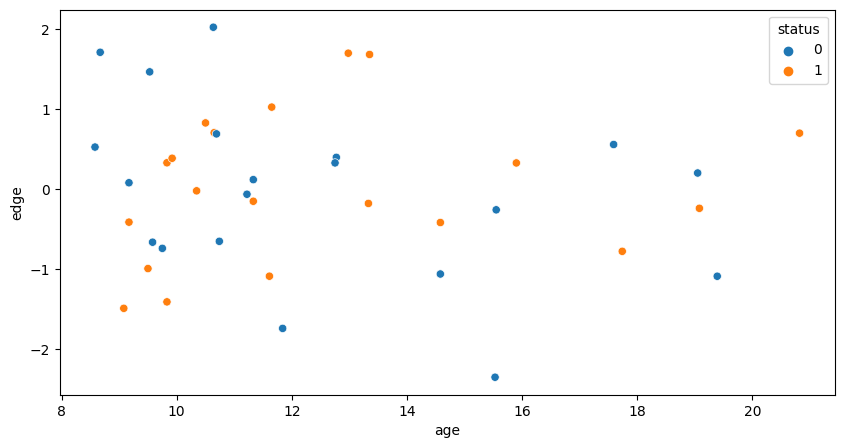

In [5]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='edge',data=pheno,hue='status')

### Fit Normative Models with Cross-Validation
The number of folds of cross-validation can be set when calling each model using the `cv_folds` parameter. By default `cv_folds=1`, no cross-validation is performed, and the metrics are estimated on the training data only.

Here we'll run each model seperately so we can see the output of the cross-validation at each fold.

In [6]:
# Initialize pynm w/ data, confounds & bin parameters
m = PyNM(pheno,'edge','status',['age','c(gender)'],bin_width=15,bin_spacing=1)

Models will be fit on full set of controls.


In [7]:
# Run Centiles model
m.centiles_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=1.412 - SMSE=1.032
CV Fold 1: RMSE=1.042 - SMSE=1.097
CV Fold 2: RMSE=1.001 - SMSE=1.145
CV Fold 3: RMSE=1.202 - SMSE=1.008
CV Fold 4: RMSE=0.594 - SMSE=1.025
Done!
Average: RMSE=1.050 - SMSE=1.061


In [8]:
# Run LOESS model
m.loess_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=1.216 - SMSE=1.023
CV Fold 1: RMSE=0.799 - SMSE=0.892
CV Fold 2: RMSE=1.145 - SMSE=1.374
CV Fold 3: RMSE=0.807 - SMSE=1.010
CV Fold 4: RMSE=1.619 - SMSE=2.092
Done!
Average: RMSE=1.117 - SMSE=1.278


In [9]:
# Run GP model
m.gp_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=1.110 - SMSE=1.225 - MSLL=-0.060
CV Fold 1: RMSE=0.544 - SMSE=1.295 - MSLL=0.123
CV Fold 2: RMSE=0.960 - SMSE=1.226 - MSLL=0.563
CV Fold 3: RMSE=1.217 - SMSE=1.022 - MSLL=0.067
CV Fold 4: RMSE=1.491 - SMSE=1.003 - MSLL=-0.084
Done!
Average: RMSE=1.064 - SMSE=1.154 - MSLL=0.122


/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

In [10]:
# Run GAMLSS model
m.gamlss_normative_model(cv_folds=5)

Starting 5 folds of CV...


/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


GAMLSS-RS iteration 1: Global Deviance = 64.4888 
GAMLSS-RS iteration 2: Global Deviance = 48.9917 
GAMLSS-RS iteration 3: Global Deviance = 43.016 
GAMLSS-RS iteration 4: Global Deviance = 41.579 
GAMLSS-RS iteration 5: Global Deviance = 40.3219 
GAMLSS-RS iteration 6: Global Deviance = 38.5801 
GAMLSS-RS iteration 7: Global Deviance = 38.7602 
GAMLSS-RS iteration 8: Global Deviance = 38.2737 
GAMLSS-RS iteration 9: Global Deviance = 36.8881 
GAMLSS-RS iteration 10: Global Deviance = 36.8218 
GAMLSS-RS iteration 11: Global Deviance = 34.1853 
GAMLSS-RS iteration 12: Global Deviance = 33.1155 
GAMLSS-RS iteration 13: Global Deviance = 28.0145 
GAMLSS-RS iteration 14: Global Deviance = 26.7796 
GAMLSS-RS iteration 15: Global Deviance = 18.8423 
GAMLSS-RS iteration 16: Global Deviance = 11.6468 
GAMLSS-RS iteration 17: Global Deviance = 9.7089 
GAMLSS-RS iteration 18: Global Deviance = 1.8253 
GAMLSS-RS iteration 19: Global Deviance = -13.8988 
GAMLSS-RS iteration 20: Global Deviance = -

### Visualize Models

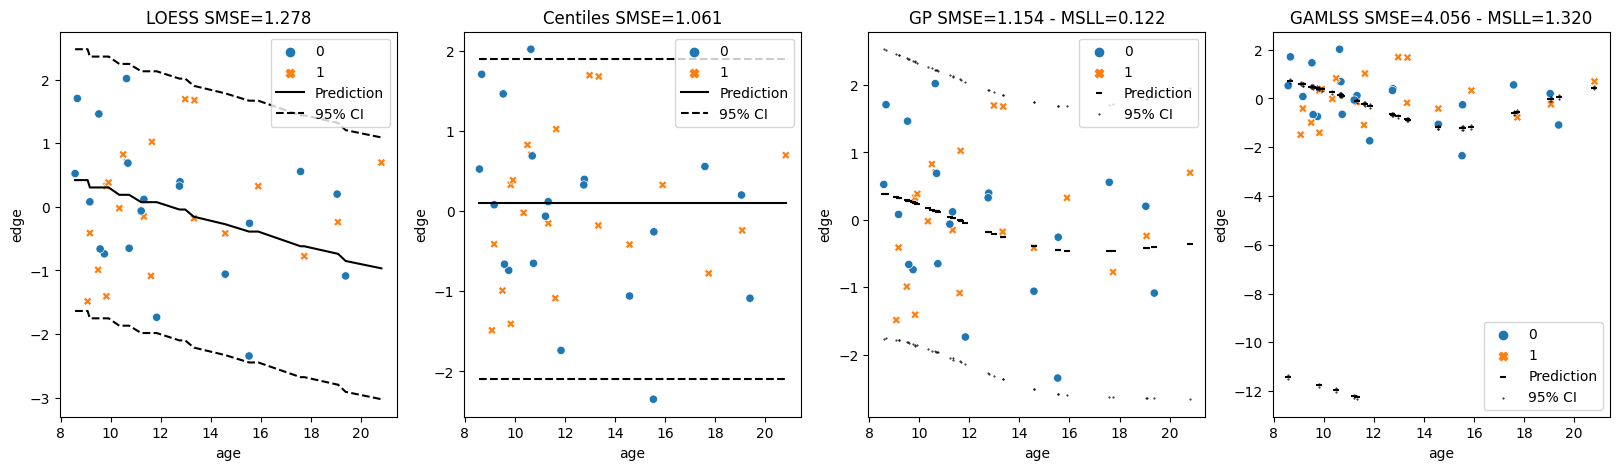

In [11]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

### Compare Metrics

We can take a quick view of all the metrics for the models that have been run automatically using the `report` function.

In [12]:
# View all the metrics for each model
m.report()

------
Report
------
========= SMSE - RMSE - MSLL
LOESS     1.28   1.12   N/A
Centiles  1.06   1.05   N/A
GP        1.15   1.06   0.12
GAMLSS    4.06   1.65   1.32


We can also access the metrics (with full precision) individually, they are stored as attributes of the PyNM object in the following format `{metric}_{model}`.

In [13]:
# View a single metric (full precision)
m.SMSE_GP

1.1540779166275565

## **Summary**
- Cross-validation is a tool to assist model selection by giving a more stable evaluation of model performance.
- PyNM implements Standardized Mean Squared Error (SMSE) and Root Mean Squared Error (RMSE) for all models, and Mean Standardized Log Loss (MSLL) for the GP and GAMLSS models.
- We can set the number of folds of cross-validation using the `cv_folds` parameter of each model.
- We can get an overview of the model evaluations using the `report` function.
- We can access the metrics individually as attributes in the format `{metric}_{model}`.

## **Resources**
- For discussion of MSLL see the Dinga et al. 2021 [preprint](https://doi.org/10.1101/2021.06.14.448106)

### **Next up:** Using results of normative modeling for downstream analyses using a held out training sample!